**Goal**<br>
The goal of this exercise is to train a deep net and to calculate---at the beginning and at the end of training---the spectrum of the Hessian using the **Lanczos** algorithm.

Our implementation will be significantly more efficient than the one in the previous exercise.

*Before you start, make sure to change the runtime type to include a GPU!*

<br>

**Task 0 (adding 3 lines of code)**<br>
Repeat task 1 from the previous PyTorch coding exercise. Namely, implement the function *Hessian_vector_multiplication* which obtains as input a vector $v \in \mathbb{R}^p$ and calculates the Hessian vector multiplication, $H v \in \mathbb{R}^{p}$.

<br>

**Task 1 (adding approximately 8 lines of code)**<br>
Implement the function Lanczos.

<br>

**Submission**<br>
*   Download your code by clicking File -> Download .ipynb
*   Submit your downloaded code on Quercus together with a PDF file of your code.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
# hyperparameters
device              = "cuda"
epochs              = 32
lr                  = 0.0679
train_batch_size    = 32
analysis_batch_size = 1024
momentum            = 0.9
weight_decay        = 5e-4

poly_deg            = 128  # the higher the parameter the better the approximation
poly_points         = 4096 # number of points in spectrum approximation
kappa               = 3    # contorls width of Gaussian bumps of spectrum

In [7]:
def ApproximateHessianSpectrum(title):
    model.eval()
    
    # Lanczos
    ritzVal, S, alpha, beta = Lanczos(poly_deg)
    
    # calculate lower bound (lb) and upper bound (ub) of spectrum
    theta_1 = ritzVal[0]
    theta_k = ritzVal[-1]
    
    s_1 = float(beta[-1]) * float(S[-1,0])
    s_k = float(beta[-1]) * float(S[-1,-1])
    
    lb = theta_1 - abs(s_1)
    ub = theta_k + abs(s_k)

    # pad a little bit the lower and upper bound
    margin = 0.05*(ub - lb)
    lb -= margin
    ub += margin

    # normalize eigenvalues to range [-1,1]
    c = (lb + ub)/2
    d = (ub - lb)/2
    ritzVal = (ritzVal - c) / d

    # width of Gaussian bumps
    H = 2 / (poly_deg - 1)
    sigma = H / np.sqrt(8 * np.log(kappa))
    width = sigma * np.sqrt(-2.0 * np.log(1e-08))

    # calculate spectrum approximation based on eigenvalues
    eigval = np.linspace(-1, 1, poly_points)
    diff = np.expand_dims(ritzVal,-1) - np.expand_dims(eigval,0)
    eigval_idx, pts_idx = np.where(np.abs(diff) < width)
    gamma2 = S[0,]**2
    vals = gamma2[eigval_idx]                                   \
         * np.exp(-((eigval[pts_idx] - ritzVal[eigval_idx])**2) \
         / (2 * sigma**2))
    density = np.zeros(poly_points)
    np.add.at(density, pts_idx, vals / np.sqrt((2 * sigma**2) * np.pi))
    
    # unnormalize spectrum approximation
    eigval = eigval*d + c
    density = density/d

    # plot spectrum
    plt.figure()
    plt.semilogy(eigval,density)
    plt.title(title)
    bottom, top = plt.ylim()
    plt.ylim((1e-20,top))

def Lanczos(M):
    v = torch.randn(p).to(device)
    v /= torch.norm(v)
    
    alpha = torch.zeros(M).to(device)
    beta = torch.zeros(M).to(device)
    
    v_prev = None
    
    for m in range(M):
        print('Lanczos Iteration: [{}/{}]'.format(m+1, M))
        
        # TASK 1: ADD CODE HERE
        if m == 0:
            v_next = Hessian_vector_multiplication(v)
        else:
            v_next = Hessian_vector_multiplication(v) - beta[m-1] * v_prev
        alpha[m] = torch.dot(v_next, v)
        v_next = v_next - alpha[m] * v
        beta[m] = torch.norm(v_next)
        v_next = v_next / beta[m]
        v_prev = v
        v = v_next

    B = np.diag(alpha.cpu().numpy()) + np.diag(beta.cpu().numpy()[:-1], k=1) + np.diag(beta.cpu().numpy()[:-1], k=-1)
    ritz_val, S = np.linalg.eigh(B)
    
    return ritz_val, S, alpha, beta

def list_to_vector(list_):
    return torch.cat([x.reshape(-1) for x in list_])

def vector_to_list(vector):
    list_ = []
    counter = 0
    for param in list(model.parameters()):
        list_.append(vector[counter:counter+torch.numel(param)].view(param.shape))
        counter += torch.numel(param)
    return list_

def Hessian_vector_multiplication(v):
    Hg = 0
    counter = 0
    
    for iter, batch in enumerate(train_loader_2):
        input, target = batch[0], batch[1]
        
        input = input.to(device)
        target = target.to(device)
        
        logits = model(input)
        
        loss = loss_function_2(logits, target)

        # TASK 0: ADD CODE HERE
        gradient = torch.autograd.grad(outputs=loss,
                                        inputs=model.parameters(),
                                        grad_outputs=None,
                                        create_graph=True)
        gradient = list_to_vector(gradient)

        hessian =  torch.autograd.grad(outputs=gradient,
                                        inputs=model.parameters(),
                                        grad_outputs=v)
        Hg += list_to_vector(hessian)

        counter += input.shape[0]
    
    return Hg / counter

Lanczos Iteration: [1/128]
Lanczos Iteration: [2/128]
Lanczos Iteration: [3/128]
Lanczos Iteration: [4/128]
Lanczos Iteration: [5/128]
Lanczos Iteration: [6/128]
Lanczos Iteration: [7/128]
Lanczos Iteration: [8/128]
Lanczos Iteration: [9/128]
Lanczos Iteration: [10/128]
Lanczos Iteration: [11/128]
Lanczos Iteration: [12/128]
Lanczos Iteration: [13/128]
Lanczos Iteration: [14/128]
Lanczos Iteration: [15/128]
Lanczos Iteration: [16/128]
Lanczos Iteration: [17/128]
Lanczos Iteration: [18/128]
Lanczos Iteration: [19/128]
Lanczos Iteration: [20/128]
Lanczos Iteration: [21/128]
Lanczos Iteration: [22/128]
Lanczos Iteration: [23/128]
Lanczos Iteration: [24/128]
Lanczos Iteration: [25/128]
Lanczos Iteration: [26/128]
Lanczos Iteration: [27/128]
Lanczos Iteration: [28/128]
Lanczos Iteration: [29/128]
Lanczos Iteration: [30/128]
Lanczos Iteration: [31/128]
Lanczos Iteration: [32/128]
Lanczos Iteration: [33/128]
Lanczos Iteration: [34/128]
Lanczos Iteration: [35/128]
Lanczos Iteration: [36/128]
L

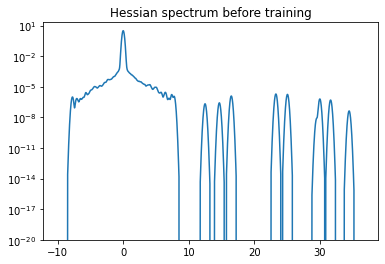

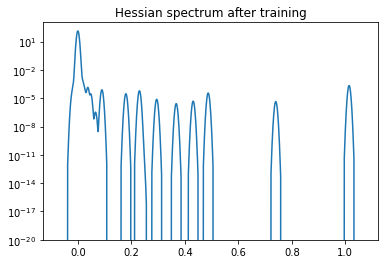

In [8]:
# dataset loaders
transform = transforms.Compose([transforms.Pad(2),
                                transforms.ToTensor(),
                                transforms.Normalize(0.2860,0.3530)])

dataset = datasets.FashionMNIST('../data', download=True, train=True, transform=transform)

# subsample dataset
subset = torch.utils.data.Subset(dataset, range(0, len(dataset), 50))

train_loader = torch.utils.data.DataLoader(subset, batch_size=train_batch_size,
                                           shuffle=True, drop_last=True)

train_loader_2 = torch.utils.data.DataLoader(subset, batch_size=analysis_batch_size,
                                             shuffle=True, drop_last=False)

# loss function
loss_function = nn.CrossEntropyLoss()

loss_function_2 = nn.CrossEntropyLoss(reduction='sum')

# deep network
model = models.resnet._resnet(models.resnet.BasicBlock,
                              layers=[1, 1, 1, 1],
                              weights=None,
                              progress=False,
                              num_classes=10)
model.conv1 = nn.Conv2d(1, model.conv1.weight.shape[0], 3, 1, 1, bias=False)
model.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
model = model.to(device)

# total_number_of_parameters
p = sum(param.numel() for param in model.parameters() if param.requires_grad)

# optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)



ApproximateHessianSpectrum('Hessian spectrum before training')

# iterate over epochs
for epoch in range(1, epochs+1):
    model.train()

    accuracy = 0
    N = 0

    # iterate over train data
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        logits = model(images)
        loss = loss_function(logits, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(logits,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

        print('Train\t\tEpoch: {} \t'
              'Batch {}/{} ({:.0f}%) \t'
              'Batch Loss: {:.6f} \t'
              'Batch Accuracy: {:.6f}'.format(
                  epoch,
                  batch_idx,
                  len(train_loader),
                  100. * batch_idx / len(train_loader),
                  loss.item(),
                  100. * accuracy/N))
        
ApproximateHessianSpectrum('Hessian spectrum after training')